In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
import math
from PIL import Image
from torchsummary import summary

%matplotlib inline

h, w = 48, 48

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

print(device)

cuda:0


In [2]:
def resize (img):
    im = Image.fromarray(img)
    im.thumbnail((h, w), Image.ANTIALIAS)
    im = np.array(im).astype('float32')
    return np.pad(im, (((h - im.shape[0]) // 2, (h - im.shape[0] + 1) // 2), ((w - im.shape[1]) // 2, (w - im.shape[1] + 1) // 2)), 'constant', constant_values=255)

In [3]:
data1 = np.load('train-1.npy')
data2 = np.load('train-2.npy')
data3 = np.load('train-3.npy')
data4 = np.load('train-4.npy')
train = np.concatenate((data1, data2, data3, data4), axis=0)

train[:, 0] = [resize(img) for img in tqdm(train[:, 0])]

del data1
del data2
del data3 
del data4

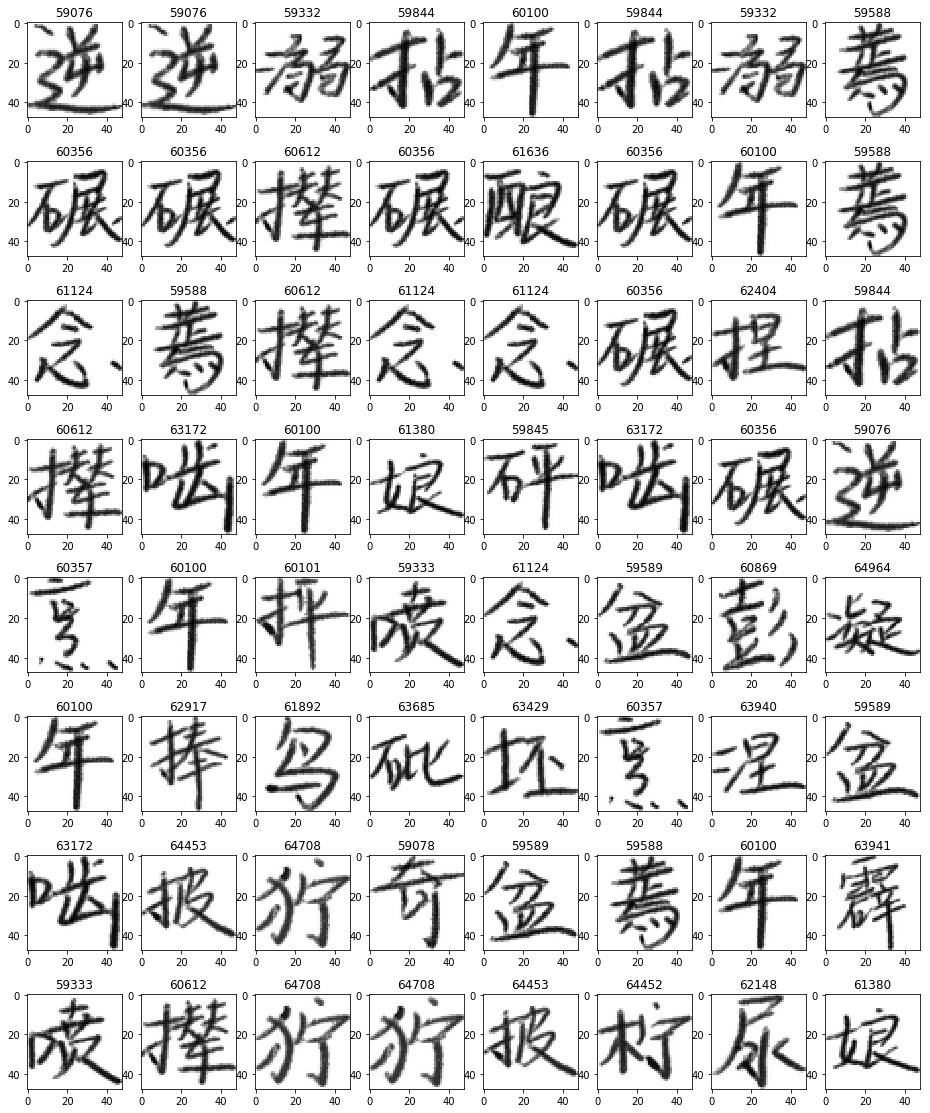

In [4]:
plt.figure(figsize=(16, 20))
for n, (image, tag) in enumerate(train, 1):
    if n > 64:
        break
    plt.subplot(8, 8, n)
    plt.title(tag)
    plt.imshow(image, cmap='gray')

In [5]:
print(train[10, 0].shape)

(48, 48)


In [6]:
dct = dict(zip(range(1000), np.unique(train[:, 1])))
dct = {v:k for k,v in dct.items()}

train[:, 1] = [dct[code] for code in train[:, 1]]

train, test = train_test_split(train, test_size=0.2, random_state=113)

In [7]:
train_x_np, train_y_np = np.array([i[:, :, np.newaxis] for i in tqdm(train[:, 0])]), np.array(train[:, 1], dtype='int32')
del train
test_x_np, test_y_np = np.array([i[:, :, np.newaxis] for i in tqdm(test[:, 0])]), np.array(test[:, 1], dtype='int32')
del test

In [8]:
import gc
gc.collect()

108327

In [9]:
class Hieroglyph_data(Dataset):
    def __init__(self, tX, tY = None,
                 transform = transforms.Compose(
                     [transforms.ToPILImage(), 
                      transforms.ToTensor(), 
                      transforms.Normalize(mean=(0.5,), std=(0.5,))]), train=True):
        
        if train == True:
            self.X = tX
            self.y = torch.Tensor(tY).type(torch.LongTensor)
            self.transform = transform
            self.train = True
            
        else:
            self.X = tX
            self.y = None
            self.transform = transform
            self.train = False
            
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if self.train == True:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [10]:
train_dataset = Hieroglyph_data(train_x_np, train_y_np, transform = transforms.Compose(
                                [transforms.ToPILImage(), 
                                 transforms.RandomAffine(
                                 degrees=(-10, 10), 
                                 translate=(.1, .1), 
                                 scale=(.9, 1.1),
                                 shear=(-10, 10)),
                                 transforms.ToTensor(), 
                                 transforms.Normalize(mean=(0.5,), std=(0.5,))]))

test_dataset = Hieroglyph_data(test_x_np, test_y_np)

In [11]:
num_classes = 1000
batch_size = 128
num_epochs = 10

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, pin_memory = True)

In [12]:
'''Dual Path Networks in PyTorch.'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    def __init__(self, last_planes, in_planes, out_planes, dense_depth, stride, first_layer):
        super(Bottleneck, self).__init__()
        self.out_planes = out_planes
        self.dense_depth = dense_depth

        self.conv1 = nn.Conv2d(last_planes, in_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=32, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.conv3 = nn.Conv2d(in_planes, out_planes+dense_depth, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes+dense_depth)

        self.shortcut = nn.Sequential()
        if first_layer:
            self.shortcut = nn.Sequential(
                nn.Conv2d(last_planes, out_planes+dense_depth, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes+dense_depth)
            )
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        x = self.shortcut(x)
        d = self.out_planes
        out = torch.cat([x[:,:d,:,:]+out[:,:d,:,:], x[:,d:,:,:], out[:,d:,:,:]], 1)
        out = F.relu(out)
        return out


class DPN(nn.Module):
    def __init__(self, cfg):
        super(DPN, self).__init__()
        in_planes, out_planes = cfg['in_planes'], cfg['out_planes']
        num_blocks, dense_depth = cfg['num_blocks'], cfg['dense_depth']

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.last_planes = 64
        self.layer1 = self._make_layer(in_planes[0], out_planes[0], num_blocks[0], dense_depth[0], stride=1)
        self.layer2 = self._make_layer(in_planes[1], out_planes[1], num_blocks[1], dense_depth[1], stride=2)
        self.layer3 = self._make_layer(in_planes[2], out_planes[2], num_blocks[2], dense_depth[2], stride=2)
        self.layer4 = self._make_layer(in_planes[3], out_planes[3], num_blocks[3], dense_depth[3], stride=2)
        self.linear = nn.Linear(out_planes[3]+(num_blocks[3]+1)*dense_depth[3], 1000)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def _make_layer(self, in_planes, out_planes, num_blocks, dense_depth, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for i,stride in enumerate(strides):
            layers.append(Bottleneck(self.last_planes, in_planes, out_planes, dense_depth, stride, i==0))
            self.last_planes = out_planes + (i+2) * dense_depth
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def DPN26():
    cfg = {
        'in_planes': (96,192,384,768),
        'out_planes': (256,512,1024,2048),
        'num_blocks': (2,2,2,2),
        'dense_depth': (16,32,24,128)
    }
    return DPN(cfg)

def DPN92():
    cfg = {
        'in_planes': (96,192,384,768),
        'out_planes': (256,512,1024,2048),
        'num_blocks': (3,4,20,3),
        'dense_depth': (16,32,24,128)
    }
    return DPN(cfg)

model = DPN92()

model = model.to(device)

summary(model, (1, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 23, 23]             576
       BatchNorm2d-2           [-1, 64, 23, 23]             128
            Conv2d-3           [-1, 96, 23, 23]           6,144
       BatchNorm2d-4           [-1, 96, 23, 23]             192
            Conv2d-5           [-1, 96, 23, 23]           2,592
       BatchNorm2d-6           [-1, 96, 23, 23]             192
            Conv2d-7          [-1, 272, 23, 23]          26,112
       BatchNorm2d-8          [-1, 272, 23, 23]             544
            Conv2d-9          [-1, 272, 23, 23]          17,408
      BatchNorm2d-10          [-1, 272, 23, 23]             544
       Bottleneck-11          [-1, 288, 23, 23]               0
           Conv2d-12           [-1, 96, 23, 23]          27,648
      BatchNorm2d-13           [-1, 96, 23, 23]             192
           Conv2d-14           [-1, 96,

In [16]:
error = nn.CrossEntropyLoss()
#error = error.to(device)

learning_rate = 0.004

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [17]:
print('wtf')

def train(epoch):
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.view(-1, 1, h, w).to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = error(outputs, labels)
        
        loss.backward()
            
        optimizer.step()
        
        if (i + 1)% 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (i+ 1) * len(images), len(train_loader.dataset),
                100. * (i + 1) / len(train_loader), loss.item()))
            
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images, labels = images.view(-1, 1, h, w).to(device), labels.to(device)

            outputs = model(images)

            loss += F.cross_entropy(outputs, labels, size_average=False).item()

            pred = outputs.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

wtf


In [18]:
for epoch in range(num_epochs):
    lr_scheduler.step()
    train(epoch)
    evaluate(test_loader)

Train Epoch: 0 [6400/266389 (2%)]	Loss: 6.606003
Train Epoch: 0 [12800/266389 (5%)]	Loss: 6.341890
Train Epoch: 0 [19200/266389 (7%)]	Loss: 6.306306
Train Epoch: 0 [25600/266389 (10%)]	Loss: 6.208392
Train Epoch: 0 [32000/266389 (12%)]	Loss: 6.044828
Train Epoch: 0 [38400/266389 (14%)]	Loss: 6.042186
Train Epoch: 0 [44800/266389 (17%)]	Loss: 5.773690
Train Epoch: 0 [51200/266389 (19%)]	Loss: 5.746150


KeyboardInterrupt: 

In [ ]:
del train_x_np
del train_y_np
#del test_x_np
#del test_y_np
del train_loader
#del test_loader
del train_dataset
#del test_dataset

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
pred = np.load('test.npy')
pred = np.array([resize(img) for img in tqdm(pred)])
pred = np.array([i[:, :, np.newaxis] for i in tqdm(pred)])
pred_dataset = Hieroglyph_data(pred, train = False)
pred_loader = torch.utils.data.DataLoader(pred_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    with torch.no_grad():
        for i, images in enumerate(data_loader):
            images = Variable(images.view(-1, 1, h, w))

            images = images.to(device)

            outputs = model(images)

            pred = outputs.cpu().data.max(1, keepdim=True)[1]

            test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [ ]:
pred_y = prediciton(pred_loader)
pred_y = pred_y.cpu().numpy().flatten()

dct = {v:k for k,v in dct.items()}

pred_y = [dct[code] for code in pred_y]

In [ ]:
import pandas as pd
results = pd.Series(pred_y, name="Category", dtype = 'object')

submission = pd.concat([pd.Series(range(1,83248), name = "Id", dtype='object'), results],axis = 1)

submission.to_csv("dpn92_64_64_no_validation.csv",index=False)